In [115]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [116]:
data = pd.read_csv('../data/processed/prepare_online_retail.csv', encoding='ISO-8859-1')

In [117]:
data_rfm = pd.read_csv('../data/processed/featured_online_retail.csv', encoding='ISO-8859-1')

data_rfm['Recency'] = pd.to_numeric(data_rfm['Recency'])
data_rfm['Frequency'] = pd.to_numeric(data_rfm['Frequency'])
data_rfm['Monetary'] = pd.to_numeric(data_rfm['Monetary'])

data_rfm["log_R"] = np.log(data_rfm.Recency)
data_rfm["log_F"] = np.log(data_rfm.Frequency)
data_rfm["log_M"] = np.log(data_rfm.Monetary)

data_rfm.shape


(4261, 12)

In [118]:
#scaler = pp.StandardScaler()
data_transformed = data_rfm[["log_R", "log_F", "log_M"]].copy()
#data_transformed = data_rfm[['Recency','Frequency','Monetary','RFM_Score']].copy()
data_transformed.describe()

,log_R,log_F,log_M
count,4261.000000,4261.000000,4261.000000
mean,3.728758,3.659169,6.572776
std,1.415719,1.312180,1.257312
min,0.000000,0.000000,1.321756
25%,2.833213,2.833213,5.712742
50%,3.912023,3.688879,6.494238
75%,4.890349,4.574711,7.399802
max,5.897154,8.921458,12.543280


In [119]:
#data_transformed_scaled = pd.DataFrame(scaler.fit_transform(data_transformed),columns= data_transformed.columns)

data_transformed_scaled = data_transformed


In [120]:
# A function to automate the model fiting and prediction
def model_train(estimator, data, a,b):
    db = []
    ca = []
    sc = []
    bic = []
    aic = []
    n_clusters = {'n_clusters':[]}
    if (estimator == AffinityPropagation)|(estimator == DBSCAN)|(estimator == OPTICS)|(estimator==Birch):
        est = estimator()
        est.fit(data)  
        labels = est.labels_
        if np.unique(est.labels_).shape[0] > 1:
            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))
            n_clusters['n_clusters'].append('N/A')
        else:
            n_clusters['n_clusters'].append(np.unique(est.labels_).shape[0])
    
    else:
        for k in range(a, b):
            if estimator == GaussianMixture:
                est = estimator(n_components= k)
                labels = est.fit_predict(data)
            else:
                est = estimator(n_clusters= k)
                est.fit(data)
                labels = est.labels_

            db.append(davies_bouldin_score(data, labels))
            ca.append(calinski_harabasz_score(data, labels))
            sc.append(silhouette_score(data, labels))

        n_clusters['n_clusters'].append(np.argmin(db) + a)
        n_clusters['n_clusters'].append(np.argmax(ca) + a)
        n_clusters['n_clusters'].append(np.argmax(sc) + a)
    return db, ca, sc, labels, n_clusters['n_clusters']

In [121]:

def plot_scores(a,b, db, ca, sc):
    fig, ax = plt.subplots(nrows= 1, ncols=3, figsize=(15,4))
    ax[0].plot(range(a, b), db, "bo-", label= 'Davies_Bouldin_Score')
    ax[1].plot(range(a, b), ca, "rx-", label = 'Calinski_Harabasz_Score')
    ax[2].plot(range(a, b), sc, "g.-", label = 'Silhouette_Score')
    ax[0].set_xlabel("$k$", fontsize=14)
    ax[1].set_xlabel("$k$", fontsize=14)
    ax[2].set_xlabel("$k$", fontsize=14)
    ax[0].set_ylabel('Davies Bouldin Score', fontsize=14)
    ax[1].set_ylabel('Calinski Harabasz Score', fontsize=14)
    ax[2].set_ylabel('Silhouette Score', fontsize=14)
    plt.show()

In [122]:
clusterers = [KMeans, AffinityPropagation, AgglomerativeClustering, Birch,
             DBSCAN, GaussianMixture, OPTICS, SpectralClustering]

Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': [],
        'n_clusters': []}

clusterer_names = ['KMeans', 'Affinity Propagation', 'Agglomerative Clustering', 'Birch',
             'DBSCAN', 'Gaussian Mixture Model', 'OPTICS', 'Spectral Clustering']

for i in clusterers:
    db, ca, sc, labels, n_clusters= model_train(i, data_transformed_scaled, 3, 8)

    Scores['Davies_Bouldin_Score'].append(np.min(db))
    Scores['Calinski_Harabasz_Score'].append(np.max(ca))
    Scores['Silhouette_Score'].append(np.max(sc))
    Scores['n_clusters'].append(n_clusters)

In [123]:
models_scores = pd.DataFrame(Scores, index= clusterer_names)
models_scores

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
KMeans,1.033058,3002.747298,0.306882,"[4, 3, 4]"
Affinity Propagation,1.005490,970.486908,0.233395,[N/A]
Agglomerative Clustering,1.116229,2597.850425,0.248976,"[3, 3, 4]"
Birch,1.244053,1681.565068,0.232866,[N/A]
DBSCAN,1.917353,87.523434,-0.053113,[N/A]
Gaussian Mixture Model,1.402857,1481.366125,0.206996,"[7, 7, 7]"
OPTICS,1.608243,9.494417,-0.476372,[N/A]
Spectral Clustering,0.468142,270.744986,0.436182,"[4, 7, 3]"


In [124]:
models_scores.loc[models_scores.Davies_Bouldin_Score == models_scores.Davies_Bouldin_Score.min()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.468142,270.744986,0.436182,"[4, 7, 3]"


In [125]:
models_scores.loc[models_scores.Calinski_Harabasz_Score == models_scores.Calinski_Harabasz_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
KMeans,1.033058,3002.747298,0.306882,"[4, 3, 4]"


In [126]:
models_scores.loc[models_scores.Silhouette_Score == models_scores.Silhouette_Score.max()]

,Davies_Bouldin_Score,Calinski_Harabasz_Score,Silhouette_Score,n_clusters
Spectral Clustering,0.468142,270.744986,0.436182,"[4, 7, 3]"


In [127]:
Scores ={'Davies_Bouldin_Score': [], 
         'Calinski_Harabasz_Score': [],
         'Silhouette_Score': []}

for k in range(3,7):
    kmeans = KMeans(n_clusters= k).fit(data_transformed_scaled)
    Scores['Davies_Bouldin_Score'].append(davies_bouldin_score(data_transformed_scaled, 
                                                               kmeans.labels_))
    Scores['Calinski_Harabasz_Score'].append(calinski_harabasz_score(data_transformed_scaled, 
                                                                     kmeans.labels_))
    Scores['Silhouette_Score'].append(silhouette_score(data_transformed_scaled, 
                                                       kmeans.labels_))

In [128]:
#Plot different measures against No. of clusters for algorithms requiring no. of clusters a priori.
def plot_scores(a,b, db, ca, sc):
    fig, ax = plt.subplots(nrows= 1, ncols=3, figsize=(15,4))
    ax[0].plot(range(a, b), db, "bo-", label= 'Davies_Bouldin_Score')
    ax[1].plot(range(a, b), ca, "rx-", label = 'Calinski_Harabasz_Score')
    ax[2].plot(range(a, b), sc, "g.-", label = 'Silhouette_Score')
    ax[0].set_xlabel("$k$", fontsize=14)
    ax[1].set_xlabel("$k$", fontsize=14)
    ax[2].set_xlabel("$k$", fontsize=14)
    ax[0].set_ylabel('Davies Bouldin Score', fontsize=14)
    ax[1].set_ylabel('Calinski Harabasz Score', fontsize=14)
    ax[2].set_ylabel('Silhouette Score', fontsize=14)
#     plt.legend(loc=(1,0),fontsize=14)
    plt.show()

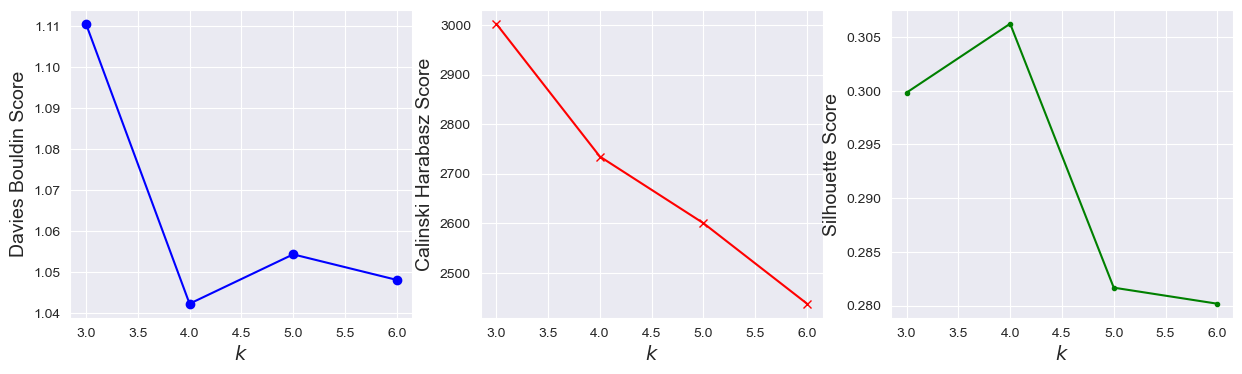

In [129]:
plot_scores(3,7,Scores['Davies_Bouldin_Score'], Scores['Calinski_Harabasz_Score'],
            Scores['Silhouette_Score'])

In [146]:
kmeans = KMeans(n_clusters=4 , max_iter= 1000 , random_state=42)
kmeans.fit(data_transformed)
data_rfm["cluster"] = kmeans.predict(data_transformed)

<Axes: >

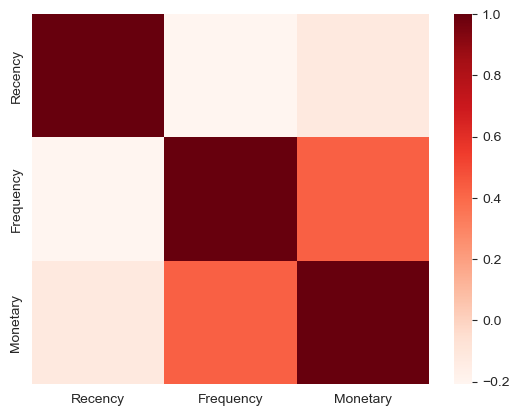

In [147]:
sns.heatmap(data_rfm[['Recency','Frequency', 'Monetary']].corr(),cmap="Reds")

In [148]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
data_rfm['cen_x'] = data_rfm.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF', '#8e7cc3']
data_rfm['c'] = data_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

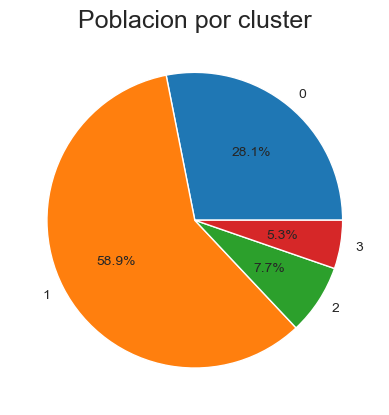

In [149]:
grouped = df_cluster.groupby('cluster')

# Contar los elementos en cada grupo
group_counts = grouped.size()

# Crear el gráfico de pastel
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%')

plt.title("Poblacion por cluster", fontsize= 18)
# Mostrar el gráfico
plt.show()

Text(0, 0.5, 'Monetary')

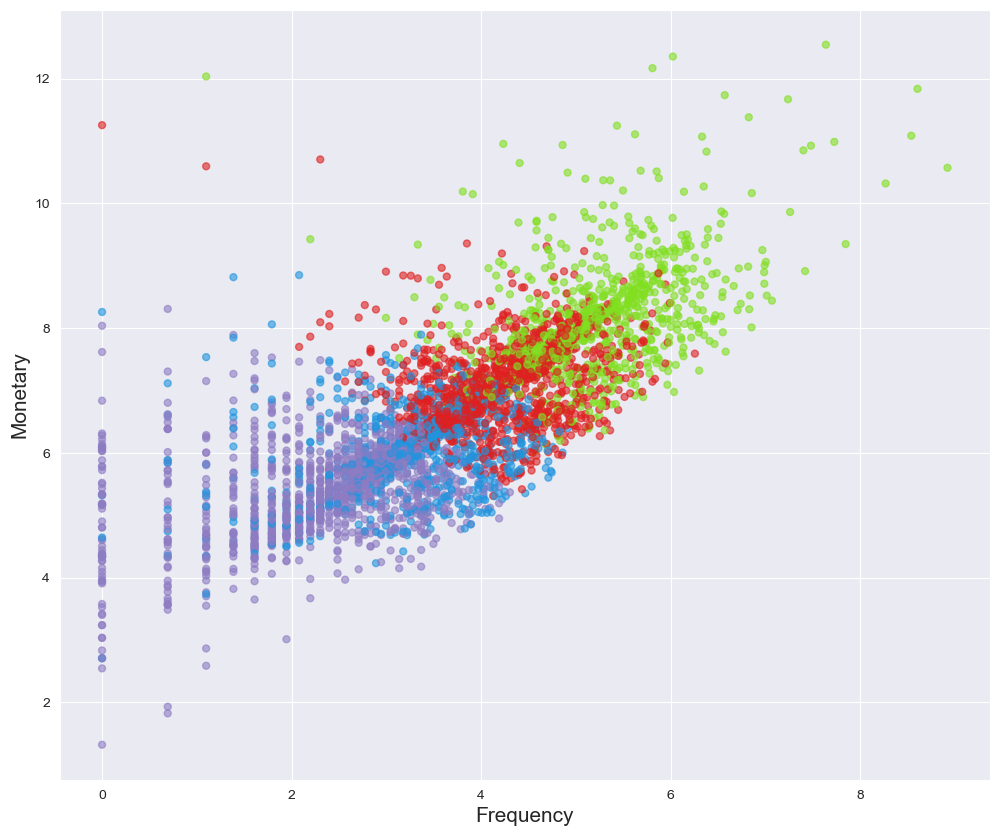

In [150]:
# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_F, data_rfm.log_M, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

Text(0, 0.5, 'Recency')

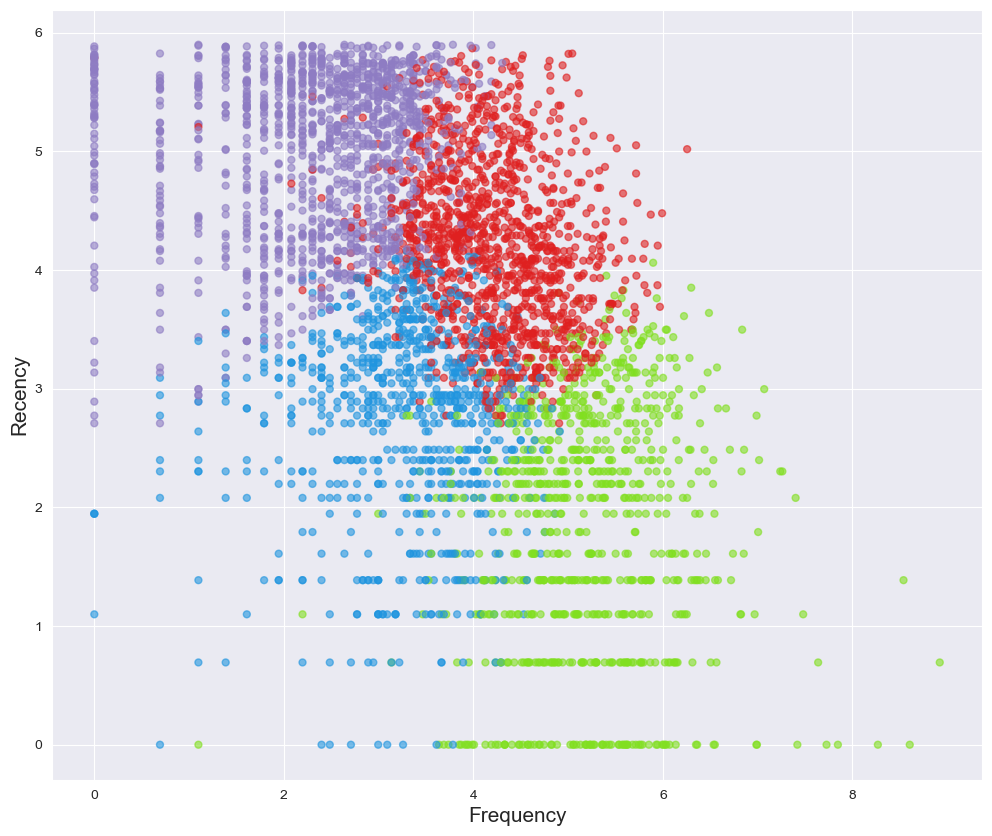

In [151]:
# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_F, data_rfm.log_R, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Recency', fontsize=15)

Text(0, 0.5, 'Recency')

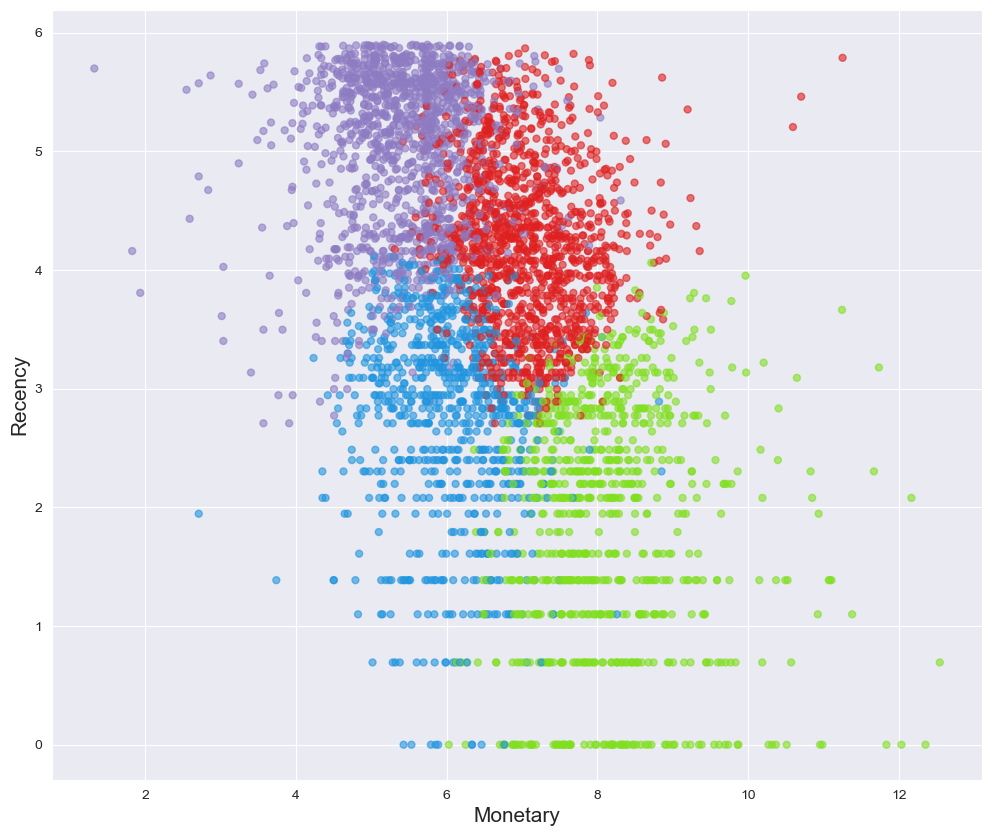

In [152]:
# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_M, data_rfm.log_R, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Monetary', fontsize=15)
plt.ylabel('Recency', fontsize=15)

Text(0.5, 0, 'Monetary')

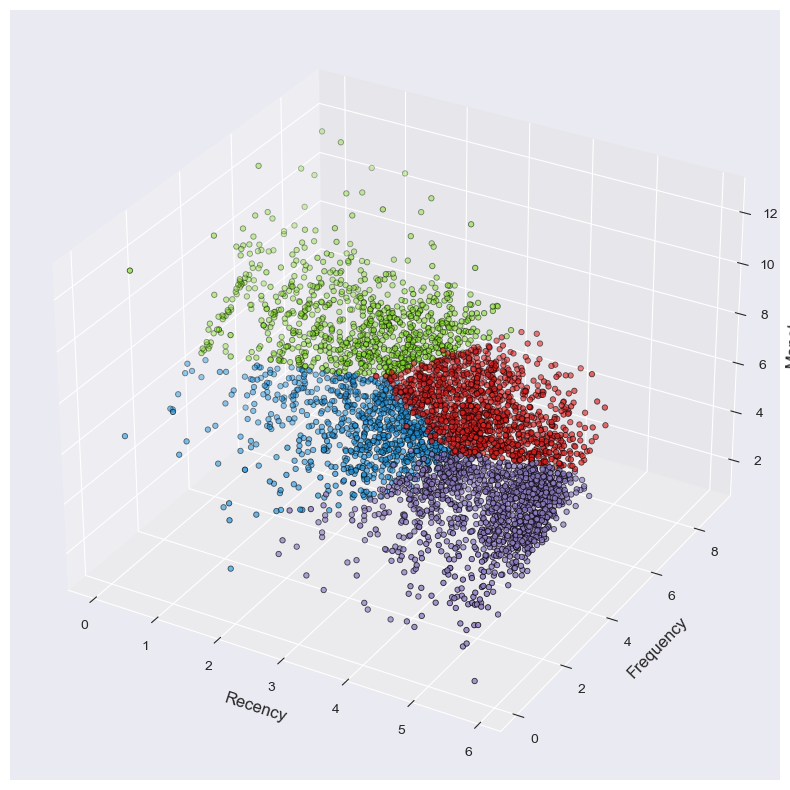

In [153]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_rfm.log_R, 
                     data_rfm.log_F, 
                     data_rfm.log_M,
                     c=data_rfm.c, 
                     s=60, 
                     marker=".",
                     cmap= 'prism', 
                     edgecolor= 'k', 
                     linewidths= 0.6)

ax.set_xlabel('Recency', fontsize= 12)
ax.set_ylabel('Frequency', fontsize= 12)
ax.set_zlabel('Monetary', fontsize= 12)

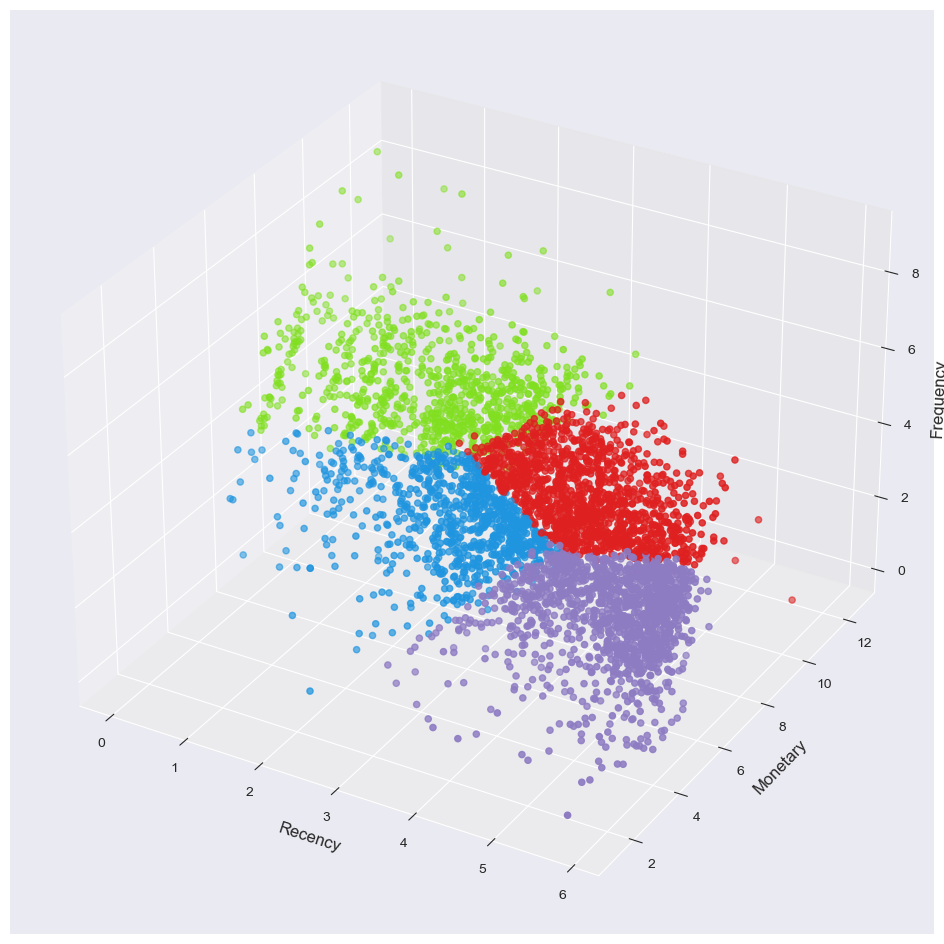

In [154]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos, usando 'c' como color
ax.scatter(data_rfm.log_R, data_rfm.log_M, data_rfm.log_F, c=data_rfm.c, cmap='viridis')

# Etiquetas de los ejes
ax.set_xlabel('log_R')
ax.set_ylabel('log_M')
ax.set_zlabel('log_F')

ax.set_xlabel('Recency', fontsize= 12)
ax.set_ylabel('Monetary', fontsize= 12)
ax.set_zlabel('Frequency', fontsize= 12)

# Mostrar la gráfica
plt.show()

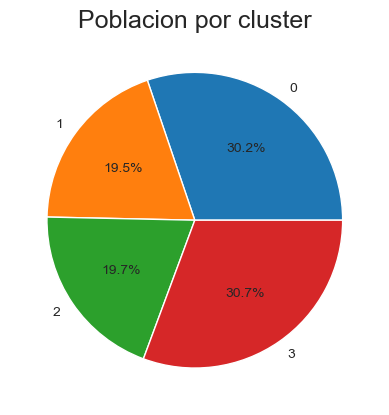

In [155]:
grouped = data_rfm.groupby('cluster')

# Contar los elementos en cada grupo
group_counts = grouped.size()

# Crear el gráfico de pastel
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%')

plt.title("Poblacion por cluster", fontsize= 18)
# Mostrar el gráfico
plt.show()

In [140]:
data_rfm.head() 

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score,log_R,log_F,log_M,cluster,cen_x,cen_y,c
0,12346.0,326,1,77183.60,0,0,3,3,3,5.786897,0.000000,11.253942,0,4.208440,4.218961,#DF2020
1,12347.0,2,151,3598.21,3,3,3,333,9,0.693147,5.017280,8.188192,1,1.916748,5.206139,#81DF20
2,12348.0,75,31,1797.24,1,1,3,113,5,4.317488,3.433987,7.494007,0,4.208440,4.218961,#DF2020
3,12349.0,19,73,1757.55,2,2,3,223,7,2.944439,4.290459,7.471676,0,4.208440,4.218961,#DF2020
4,12350.0,310,17,334.40,0,0,1,1,1,5.736572,2.833213,5.812338,3,NaN,NaN,#8e7cc3


In [141]:
 data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [142]:
df_cluster = pd.merge(data, data_rfm, on='CustomerID', how='right')

In [143]:
df_cluster.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_sales,Recency,...,M_score,RFM,RFM_Score,log_R,log_F,log_M,cluster,cen_x,cen_y,c
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.6,326,...,3,3,3,5.786897,0.00000,11.253942,0,4.208440,4.218961,#DF2020
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/7/2010 14:57,2.10,12347.0,Iceland,25.2,2,...,3,333,9,0.693147,5.01728,8.188192,1,1.916748,5.206139,#81DF20
2,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/7/2010 14:57,4.25,12347.0,Iceland,17.0,2,...,3,333,9,0.693147,5.01728,8.188192,1,1.916748,5.206139,#81DF20
3,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/7/2010 14:57,3.25,12347.0,Iceland,39.0,2,...,3,333,9,0.693147,5.01728,8.188192,1,1.916748,5.206139,#81DF20
4,537626,22492,MINI PAINT SET VINTAGE,36,12/7/2010 14:57,0.65,12347.0,Iceland,23.4,2,...,3,333,9,0.693147,5.01728,8.188192,1,1.916748,5.206139,#81DF20


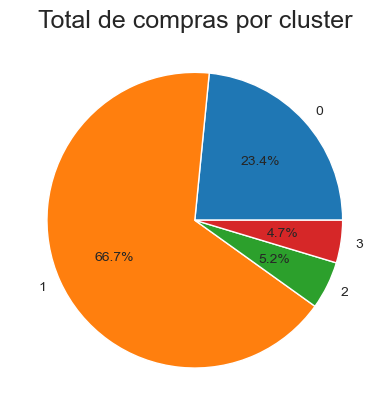

In [158]:
grouped = df_cluster.groupby('cluster')['Total_sales'].sum()

# Crear el gráfico de pastel
plt.pie(grouped, labels=grouped.index, autopct='%1.1f%%')

plt.title("Total de compras por cluster", fontsize= 18)
# Mostrar el gráfico
plt.show()